# **Problem Statement**

Artificial Intelligence has revolutionized the healthcare industry from:
1. Medical Imagery
2. Drug Research
3. Genome Development

Deep Learning has been proven to outperform humans in detecting and classifying disease. In dermatology, for example, skin cancer could be detected more accurately by deep learning(95% accuracy) than dermatologists(86.6% accuracy)

**In this case study, I will automate the process of detecting and classifying chest disease from X-Ray images to reduce the cost and time in detection**

This dataset contains 133 X-Ray images that belong to 
1. Healthy
2. Covid-19
3. Bacterial Pneumonia
4. Viral Pneumonia

# **IMPORT LIBRARIES AND DATASET**

In [4]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 
# setting the style of the notebook to be monokai theme  
# this line of code is important to ensure that we are able to see the x and y axes clearly
# If you don't run this code line, you will notice that the xlabel and ylabel on any plot is black on black and it will be hard to see them. 


In [5]:
# Specify training data directory
XRay_Directory = 'Chest_X_Ray/train'

In [6]:
# List the folders in the directory
os.listdir(XRay_Directory)

['0', '1', '2', '3']

In [9]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

In [10]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                     directory = XRay_Directory,
                                                     shuffle = True,
                                                     target_size=(256,256),
                                                     class_mode = 'categorical',
                                                     subset = 'validation')


Found 104 images belonging to 4 classes.


In [11]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = XRay_Directory, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation")


Found 104 images belonging to 4 classes.


In [12]:
# Generate a batch of 40 images and labels
!pip install pillow
train_images, train_labels = next(train_generator)


You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [13]:
train_labels

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]],

In [14]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

In [15]:
train_images.shape

(40, 256, 256, 3)

In [16]:
train_labels.shape

(40, 4)

# **DATA VISUALIZATION**

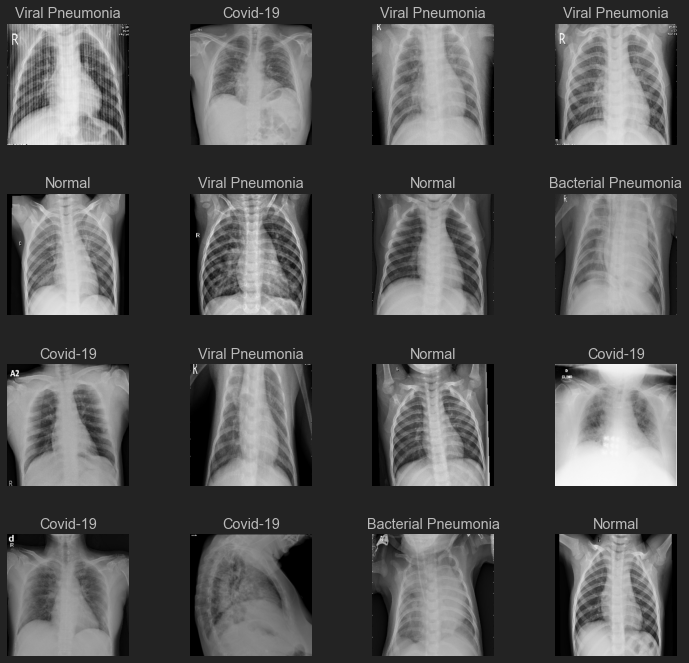

In [20]:
# Create a grid of 16 images along with their corresponding labels
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

# **What is ResNet & Transfer Learning**

A `ResNet` model is a pretrained model consisting of Convolutional Neural Networks(CNN) that are used to extract high level general features from images. At the last few layers, which I will add while freezing the first layers, are used to classify images based on the 4 classes. The layers that make up the model are able to scan the image first searching for simple edges/lines which are then picked up by the subsequent layer to perform more complex features.

In addition, Resnet models are trained on `ImageNet` which contains 11 million images and 11,000 categories

`Transfer Learning` is a machine learning technique in which a netwrok that has been trained to perform a specific task is reused/repurposed to perform a different or similar task. Such technique reduces the computational time required; ie: intelligence is being repurposed for a different task

# **Import ResNet50 Model**

In [22]:
base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))


In [23]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in base_model.layers[:-10]:
  layers.trainable = False

# **TRAIN RESNET50 MODEL**

In [25]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size = (4,4))(head_model)
head_model = Flatten(name = 'flatten')(head_model)
head_model = Dense(256, activation ='relu')(head_model)
head_model = Dropout(0.3)(head_model) # regularization technique to improve generalization
head_model = Dense(128, activation ='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

model = Model(inputs = base_model.input, outputs = head_model)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## **Compile the Model**

In [29]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics= ["accuracy"])

In [30]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [31]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


## **Fit The Model**

In [32]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 1, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107 steps, validate for 26 steps
106/107 [============================>.] - ETA: 7s - loss: 0.8545 - accuracy: 0.7288 
Epoch 00001: val_loss improved from inf to 4.37830, saving model to weights.hdf5
107/107 [==============================] - 807s 8s/step - loss: 0.8541 - accuracy: 0.7290 - val_loss: 4.3783 - val_accuracy: 0.2500


## **Save the Model**

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
# load json and create model

from tensorflow.keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("chestdisease_trained_model.h5")
print("Loaded model from disk")


Loaded model from disk


# **Evaluate the Model**

In [37]:
# Let's compile the model 
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [38]:
test_directory = 'Chest_X_Ray/Test'


In [34]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
 1/10 [==>...........................] - ETA: 1:47 - loss: 1.3360 - accuracy: 0.8000Accuracy Test : 0.800000011920929


In [39]:
!pip install opencv-python

You should consider upgrading via the 'c:\users\administrator\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [41]:
len(original)

40

In [42]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


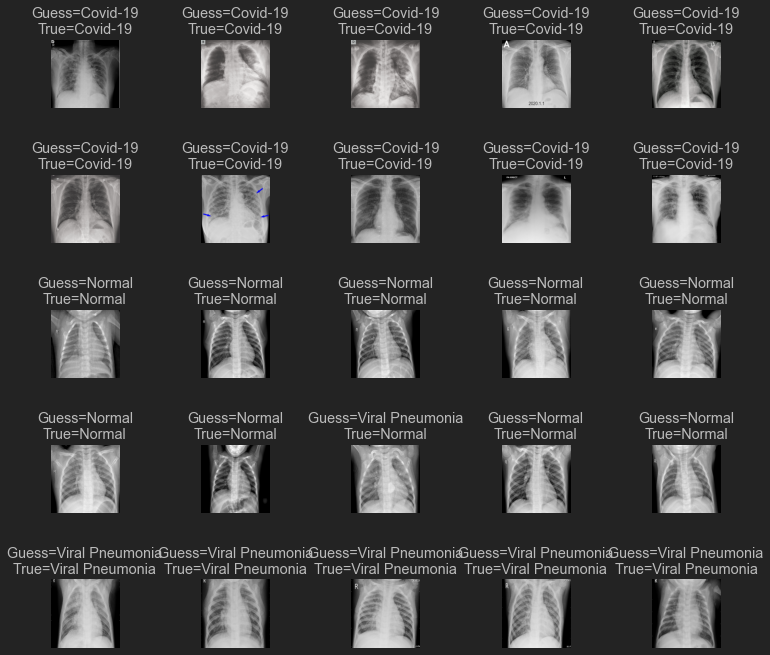

In [43]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [44]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.82      0.90      0.86        10
           2       0.67      0.60      0.63        10
           3       0.86      0.60      0.71        10

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.77        40



Text(0.5, 1.0, 'Confusion_matrix')

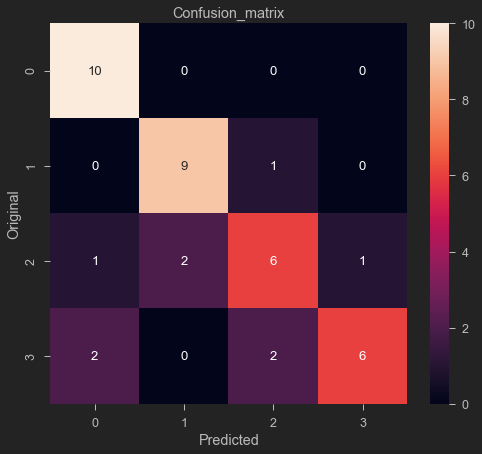

In [45]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')